In [1]:
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model

import warnings
warnings.filterwarnings("ignore")

## Takeaways from EDA

## <span style="color:red">Overall EDA Takeaways & Questions answered:</span>

 
 What Factors contribute the most to churn from customers?
  - is male (not significant)
  - has partner (not significant)
  
What factors from the business have the highest contribution to churn?
  - Fiber optic Internet service
  - Electronic Check
  - Paperless billing
  
 ### Project Questions:

- Is churn customer or feature driven?
    - Feature
    
- Are any groups of churn higher than the average rate? 
    a. Of those groups, are there any subgroups who churn? 
        - has_phone_service_Yes, has_multiple_lines_No phone service', has_paperless_billing_Yes,
        - internet_service_type_Fiber optic, payment_type_Electronic check
    b. What services lead to higher churn?
        - internet_service_type_Fiber optic, payment_type_Electronic check

- Is there a significant difference between the internet and phone services for those who churn?
    - Fiber optic has most significance when determining Churn
    
- Is there a significant difference between payment methods that drive churn?
    - Electronic Checks have strong significance when determining Churn

In [2]:
df = get_telco_data()
df = prep_telco(df)

Using cached csv


In [3]:
# Determine the categorical variables - here defined as object data type (non-numeric) and with fewer than 5 values
catcol = df.columns[(df.nunique()<5)&(df.dtypes == 'object')]
# Encode categoricals
dummy_df = pd.get_dummies(df[catcol], dummy_na=False, drop_first=True)
# Concatenate dummy df to original df
df = pd.concat([df,dummy_df],axis=1)
# Remove the original categorical columns after encoding
df = df.drop(columns=catcol)
df=df.drop(columns = ['has_streaming'])

In [4]:
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

In [5]:
# Baseline churn rate
baseline_churn = (train.churn == 0).mean()
baseline_churn

0.7343154686309372

In [6]:
train.columns

Index(['customer_id', 'is_senior_citizen', 'tenure', 'monthly_charges',
       'total_charges', 'churn', 'is_male', 'has_phone',
       'has_internet_service', 'has_partner', 'has_dependent', 'is_paperless',
       'is_month_to_month', 'is_autopay', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', 'payment_type_Credit card (automatic)',
       'payment_type_Electronic check', 'payment_type_Mailed check'],
      dtype='object')

In [7]:
# features based on initial data set
# features =['monthly_charges','is_autopay','has_internet_service', 'is_month_to_month', 'has_streaming', 'is_senior_citizen', 'is_paperless']
# group_features = ['contract_type','internet_service_type', 'payment_type']
# features from eda
features = ['monthly_charges','is_autopay','is_paperless','internet_service_type_Fiber optic', 'payment_type_Electronic check']
target = 'churn'

In [8]:
x_train = train[features]
y_train = train[[target]]

x_validate = validate[features]
y_validate = validate[[target]]

x_test = test[features]
y_test = test[[target]]

# Decision Tree

In [9]:
# Checking split
x_train[:5]

,monthly_charges,is_autopay,is_paperless,internet_service_type_Fiber optic,payment_type_Electronic check
5919,71.10,1,1,0,0
1915,85.45,1,1,1,0
5054,25.75,0,1,0,1
2355,19.20,0,0,0,0
6279,54.00,0,0,0,0


In [10]:
y_train[:5]

,churn
5919,0
1915,0
5054,0
2355,0
6279,0


In [11]:
tree = DecisionTreeClassifier(max_depth = 3)

In [12]:
tree= tree.fit(x_train,y_train)

In [13]:
y_pred = tree.predict(x_train)

In [14]:
# Evaluate your in-sample results using the model score, confusion matrix, and classification report.
print(f'Accuracy score on training set is: {tree.score(x_train,y_train):.2%}')

Accuracy score on training set is: 76.96%


In [15]:
labels = sorted(y_train.churn.unique())
pd.DataFrame(confusion_matrix(y_train, y_pred), index = labels, columns = labels)

,0,1
0,2729,162
1,745,301


In [16]:
#copied from model.ipynb in classification-exercises repository - adjusted from titanic data set
def decision_tree_train(x_train, y_train, features=features, target=target, d = 10, m=1, print_results = True):
  
    clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf = m, random_state=123)
    clf = clf.fit(x_train, y_train)
    accuracy = clf.score(x_train, y_train)
    y_pred = clf.predict(x_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print("----------------")
        print(f"Accuracy score on training set is: {accuracy:.2f}")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'d':clf.max_depth, 
                    'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def classifier_validate(x_validate, y_validate, clf, print_results=True):
    d = clf.max_depth
    accuracy = clf.score(x_validate, y_validate)


    # Produce y_predictions that come from the x_validate
    y_pred = clf.predict(x_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {selected_features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'d':clf.max_depth, 
                       'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [17]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = decision_tree_train(x_train, y_train, d=d, m = min_sample , print_results=False)
        validate_report = classifier_validate(x_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

In [18]:
train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n{combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
print(f"This was a drop-off from train of:\n{combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

decision_tree_final_results = combined_df
decision_tree_final_results["model"] = 'decision_tree'

Highest accuracy score on train:
 0.808737617475235 with max depth setting of 9 and min_sample_leaf of 1
Highest accuracy score on validate:
0.745260663507109 with max depth setting of 7 and min_sample_leaf of 3
This was a drop-off from train of:
-0.037822902660023416
Lowest drop-off in accuracy from train to validate:
 -0.00031072929444431185 with max depth setting of 1 and min sample leaf of  1


[Text(0.5546195652173913, 0.95, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]'),
 Text(0.3311141304347826, 0.85, 'payment_type_Electronic check <= 0.5\ngini = 0.241\nsamples = 2215\nvalue = [1904, 311]'),
 Text(0.19972826086956522, 0.75, 'monthly_charges <= 27.55\ngini = 0.197\nsamples = 1788\nvalue = [1590, 198]'),
 Text(0.1, 0.65, 'is_autopay <= 0.5\ngini = 0.138\nsamples = 820\nvalue = [759, 61]'),
 Text(0.04891304347826087, 0.55, 'is_paperless <= 0.5\ngini = 0.169\nsamples = 430\nvalue = [390, 40]'),
 Text(0.02391304347826087, 0.45, 'monthly_charges <= 21.075\ngini = 0.133\nsamples = 321\nvalue = [298, 23]'),
 Text(0.01956521739130435, 0.35, 'monthly_charges <= 19.425\ngini = 0.157\nsamples = 268\nvalue = [245, 23]'),
 Text(0.008695652173913044, 0.25, 'monthly_charges <= 19.075\ngini = 0.048\nsamples = 41\nvalue = [40, 1]'),
 Text(0.004347826086956522, 0.15, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]'),
 Text(0.013043478260869565, 0.

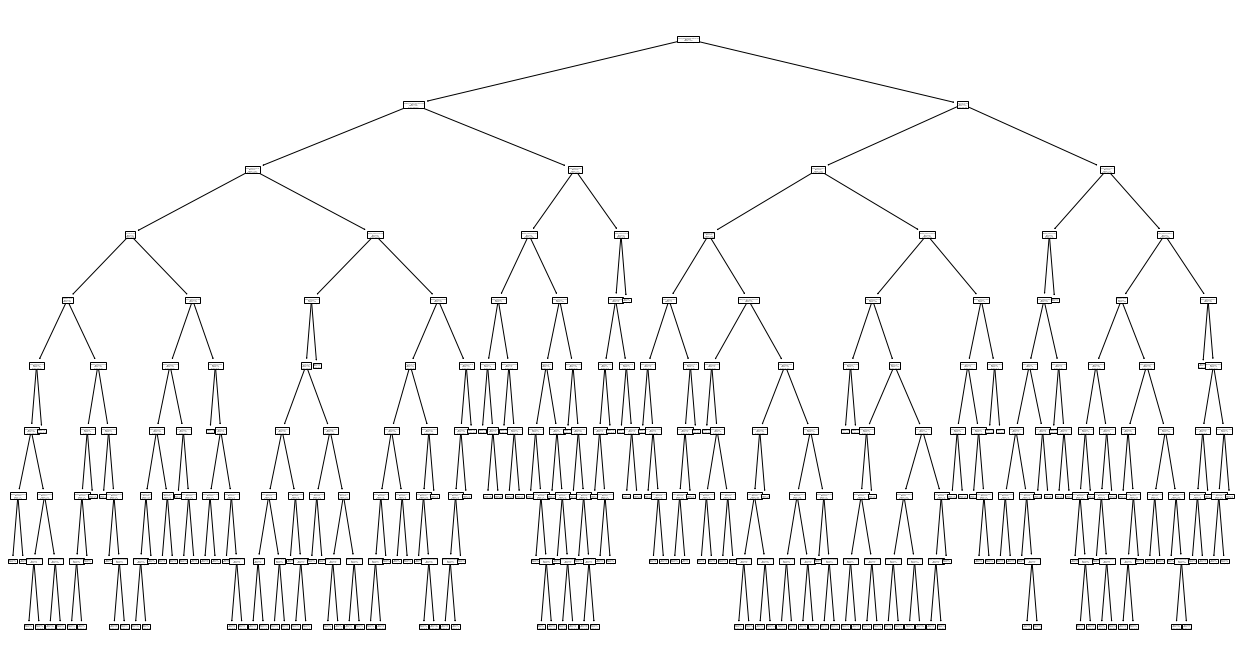

In [19]:
plt.figure(figsize=(22, 12))
plot_tree(clf,feature_names=x_train.columns)

In [20]:
# train score
clf.score(x_train,y_train)

0.794259588519177

In [21]:
# Accuracy of out-of-sample data
clf.score(x_validate, y_validate) 

0.7316350710900474

In [22]:
y_validate.value_counts(normalize=True)

churn
0        0.734005
1        0.265995
dtype: float64

### Decision tree Takeaway:
 - Decision Tree Basic:
    - Baseline 73.4%
    - train accuracy(depth= 1) 79.16% 

- Train model was most accurate with max depth setting of 9 and min_sample_leaf of 1
   - 80.8%
- Validate was most accurate with max depth setting of 7 and min_sample_leaf of 3
   - 74.5%

### <span style="color:red"> Decision Tree conclusion </span>

 - Train more accurate at depth of 9
 - validate only slightly more accurate than baseline 
 

# Random Forest

In [23]:
# Pulled from model.ipynb in the classification-exercises repository, updated for 'churn'
def random_forest(train, validate,features , min_samples_leaf, d, print_results = True):
    
    x_train = train[features]
    y_train = train[['churn']]
    rf = RandomForestClassifier(max_depth=d, min_samples_leaf=min_samples_leaf, random_state=123)
    # Fit
    rf = rf.fit(x_train, y_train['churn'])
    
    # Predict
    y_pred = rf.predict(x_train)
    
    # Results
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    if print_results:
        print("TRAINING RESULTS")
        print("----------------")
        # Feature importance
        print(f"Feature importance:\n{dict(zip(features,rf.feature_importances_))}")
        print(f"Accuracy of random forest classifer on training set: {rf.score(x_train, y_train):.2%}")
        print(classification_report(y_train, y_pred))

        
        print("Confusion matrix: rows are truth, columns are pred")
        print("")
        print(confusion_matrix(y_train, y_pred))
        print("")
        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    train_report = classification_report(y_train, y_pred, output_dict=True)
    ### Predict for Validate 
    y_pred_val = rf.predict(validate[features])
    ### Classification report
    validate_report = classification_report(validate[['churn']],y_pred_val, output_dict=True)
    if print_results:
        print("VALIDATE RESULTS")
        print("----------------")
        print(classification_report(validate[['churn']],y_pred_val))
    reports = {'train':train_report,'validate':validate_report}
    return reports

In [24]:
features =['monthly_charges','is_autopay','has_internet_service', 'is_month_to_month', 'is_senior_citizen', 'is_paperless']
# group_features = ['contract_type','internet_service_type', 'payment_type']
# eda_features = ['internet_service_type_Fiber optic', 'payment_type_Electronic check']
random_forest(train,validate,features,1,10,True)

TRAINING RESULTS
----------------
Feature importance:
{'monthly_charges': 0.5753395911605481, 'is_autopay': 0.0567405893598473, 'has_internet_service': 0.04653853590554195, 'is_month_to_month': 0.2623668482093574, 'is_senior_citizen': 0.023380328109300148, 'is_paperless': 0.035634107255405174}
Accuracy of random forest classifer on training set: 84.66%
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2891
           1       0.74      0.65      0.69      1046

    accuracy                           0.85      3937
   macro avg       0.81      0.78      0.79      3937
weighted avg       0.84      0.85      0.84      3937

Confusion matrix: rows are truth, columns are pred

[[2657  234]
 [ 370  676]]

False positive rate: 8.09%
False negative rate: 35.37%
True positive rate: 64.63%
True negative rate: 91.91%
----------------
VALIDATE RESULTS
----------------
              precision    recall  f1-score   support

           0       0.81

{'train': {'0': {'precision': 0.8777667657746944,
   'recall': 0.9190591490833622,
   'f1-score': 0.8979384927340318,
   'support': 2891},
  '1': {'precision': 0.7428571428571429,
   'recall': 0.6462715105162524,
   'f1-score': 0.6912065439672802,
   'support': 1046},
  'accuracy': 0.8465836931673864,
  'macro avg': {'precision': 0.8103119543159186,
   'recall': 0.7826653297998073,
   'f1-score': 0.794572518350656,
   'support': 3937},
  'weighted avg': {'precision': 0.8419233658326677,
   'recall': 0.8465836931673864,
   'f1-score': 0.8430130118069243,
   'support': 3937}},
 'validate': {'0': {'precision': 0.8066770186335404,
   'recall': 0.8385794995964487,
   'f1-score': 0.8223189552829443,
   'support': 1239},
  '1': {'precision': 0.5,
   'recall': 0.44543429844098,
   'f1-score': 0.47114252061248524,
   'support': 449},
  'accuracy': 0.7340047393364929,
  'macro avg': {'precision': 0.6533385093167702,
   'recall': 0.6420068990187143,
   'f1-score': 0.6467307379477147,
   'support'

In [25]:
for i in range (2,11):
    rfc = RandomForestClassifier(max_depth=i, random_state=123)
    rfc = rfc.fit(x_train,y_train)
    #predictions
    y_pred = rfc.predict(x_train)
    # Classification loop
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.771790     0.720000  0.767844     0.745895      0.758030
recall        0.970944     0.206501  0.767844     0.588723      0.767844
f1-score      0.859988     0.320951  0.767844     0.590469      0.716774
support    2891.000000  1046.000000  0.767844  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.786067     0.628049   0.76632     0.707058      0.744084
recall        0.936700     0.295411   0.76632     0.616056      0.766320
f1-score      0.854798     0.401821   0.76632     0.628309      0.734449
support    2891.000000  1046.000000   0.76632  3937.000000   3937.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.781134     0.649533  0.766828     0.715333      0.746170
recall        0.948115     0.265774  0.766828  

In [26]:
# Copied from decision tree lesson & updted with random forest classifier
metrics = []

for i in range(1, 25):
    # Make the model
    rfc = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    rfc = rfc.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = rfc.score(x_train, y_train)
    
    out_of_sample_accuracy = rfc.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.734315,0.734005,0.000311
1,2,0.767844,0.739929,0.027915
2,3,0.766320,0.746445,0.019874
3,4,0.766828,0.749408,0.017420
4,5,0.778004,0.746445,0.031558
5,6,0.786132,0.749408,0.036724
6,7,0.795276,0.754739,0.040536
7,8,0.811024,0.753555,0.057469
8,9,0.828550,0.745853,0.082697
9,10,0.846330,0.742299,0.104031


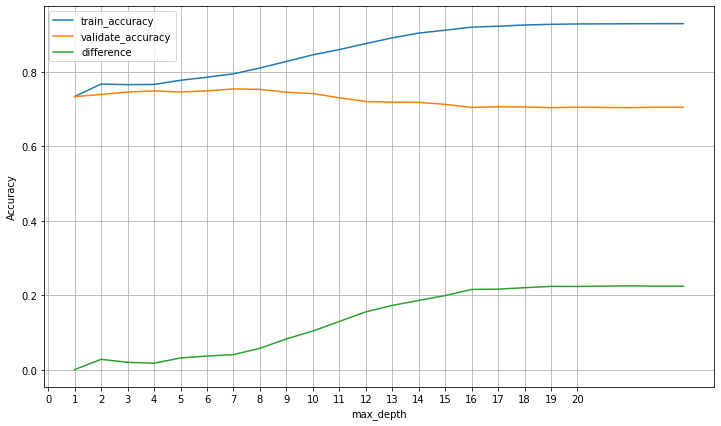

In [27]:
df.set_index('max_depth').plot(figsize = (12,7))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

## Random Forest Takeaway:

  - Max depth of 4 gave accuracy on train :0.7780	 Validate: 0.7464	
  -  This is a difference of 0.058572 - approximately 95% similar

<span style="color:red"> Conclusion </span>
 - Random forest model with max depth of 4 gave best scenario
 - Not much difference the baseline rate

# KNN

In [28]:
# Copied from model.py file
# modle.py file was not imported due to errors occuring in other functions
def knn_train(x_train, y_train, eatures=features, target=target, k=1, print_results = True):
  
    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    accuracy = clf.score(x_train, y_train)
    y_pred = clf.predict(x_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {features}")
        print(f"K of {clf.n_neighbors}")
        print("----------------")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def knn_validate(x_validate, y_validate, clf, print_results=True):
    accuracy = clf.score(x_validate, y_validate)


    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(x_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {features}")
        print(f"K of {clf.n_neighbors}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [29]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

k_range = range(1,100)
for k in k_range:

    clf, train_report = knn_train(x_train, y_train, k=k, print_results=False)
    validate_report = knn_validate(x_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

In [31]:
train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['k'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with k setting of {combined_df.k[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {combined_df.accuracy_validate.max()} with k setting of {combined_df.k[combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.min()} with k setting of {combined_df.k[combined_df.accuracy_diff == combined_df.accuracy_diff.min()].array[0]}")

knn_final_results = combined_df
knn_final_results["model"] = 'k_nearest_neighbors'

Highest accuracy score on train:
 0.9171958343916687 with k setting of 1
Highest accuracy score on validate:
 0.7511848341232228 with k setting of 26
Lowest drop-off in accuracy from train to validate:
 -0.22939962586086304 with k setting of 1


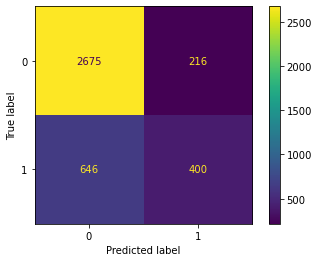

In [44]:
k=26
knn = KNeighborsClassifier(n_neighbors = k)
knn = knn.fit(x_train, y_train)
plot_confusion_matrix(knn,x_train, y_train)

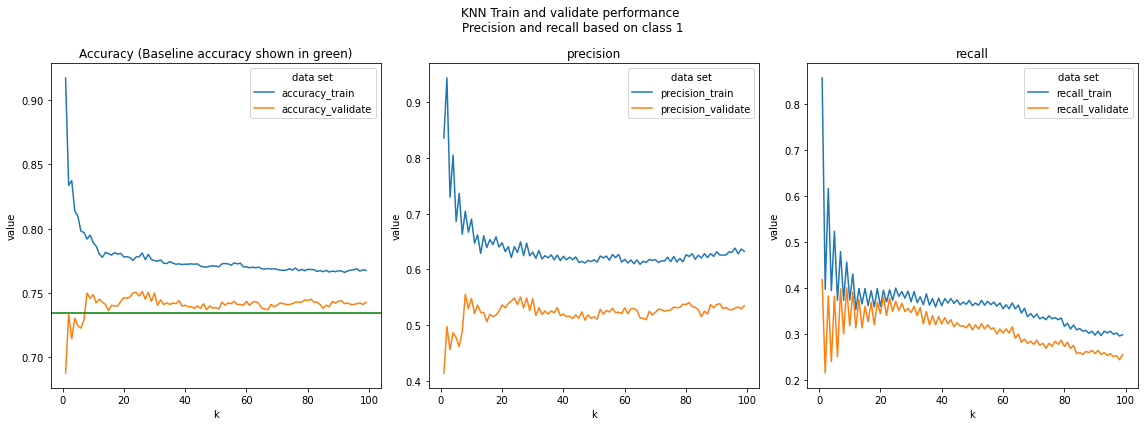

In [32]:
# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['k'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].k, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'KNN Train and validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_churn, color = 'green')

# Logistical Regression

In [33]:
# from Modeling.py
def logistic_regression(train, features, target, c, validate = None, test = None, print_results = True):
    
    x_train = train[features]
    y_train = train[target]
    logit = LogisticRegression(C=c,random_state=123, max_iter=1000)
    # Fit
    logit = logit.fit(x_train, y_train)
    
    # Predict
    y_pred = logit.predict(x_train)
    
    # Results
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    if print_results:
        print("----------------")
        print(f"USING c OF {logit.C}")
        print("TRAINING RESULTS")
        print("----------------")
        # Feature importance
        print(selected_features)
        print('Coefficient: \n', logit.coef_)
        print('Intercept: \n', logit.intercept_)
        
        
        print(f"Accuracy of logistic regression classifer on training set: S{logit.score(x_train, y_train):.2%}")
        print(classification_report(y_train, y_pred))

        
        print("Confusion matrix: rows are truth, columns are pred")
        print("")
        print(confusion_matrix(y_train, y_pred))
        print("")
        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    train_report = classification_report(y_train, y_pred, output_dict=True)
    if validate is not None:
        ### Predict for Validate 
        y_pred_val = logit.predict(validate[features])
        ### Classification report
        validate_report = classification_report(validate[target],y_pred_val, output_dict=True)
        if print_results:
            print("----------------")
            print(f"USING c OF {logit.C}")
            print("VALIDATE RESULTS")
            print("-------Logistic Regression---------")
            print(classification_report(validate[target],y_pred_val))
    else:
        validate_report = None
        
    ## Test set performance
    if test is not None:
        ### Predict for Validate 
        y_pred_test = logit.predict(test[features])
        ### Classification report
        test_report = classification_report(test[target],y_pred_test, output_dict=True)
        if print_results:
            print("----------------")
            print(f"USING c OF {logit.C}")
            print("TEST RESULTS")
            print("-------Logistic Regression---------")
            print(classification_report(test[target],y_pred_test))
    else:
        test_report = None
    reports = {'train':train_report,'validate':validate_report, 'test':test_report}
    return reports

# Performance Report 


def plot_train_validate_performance(train_results_df, validate_results_df):
    # Combine train and validate results to allow for plotting together
    combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
    combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
    combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
    combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train
    
    # Melt metrics into same column to enable clean plotting with seaborn
    data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']),
                   id_vars =['c'], var_name='metric')
    
    # Plot train and validate performance
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy","precision","recall"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                     y = data[data.metric.str.contains(metric)].value, 
                     hue = data[data.metric.str.contains(metric)].metric,  
                     ax=ax[i])

        plt.suptitle('Train and validate performance')
        plt.tight_layout()

        ax[i].legend(title = 'data set')
        ax[i].set_title(metric)
        # if metric == "accuracy":
        #     ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        #     ax[i].axhline(baseline_accuracy, color = 'green')
    
    # Plot performance difference between train and validate
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy_diff","precision_diff","recall_diff"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = combined_df.c, y = combined_df[metric], ax=ax[i])
        plt.suptitle('Difference between validate and train performance')
        ax[i].set_title(metric)
        plt.tight_layout()
    
    return combined_df

In [34]:
#Logistical regression data points to be copy and pasted in notebook
cs =[]
accuracies = []
precisions = []
recalls = []
v_accuracies = []
v_precisions = []
v_recalls = []
c_values = [0.01, 0.1, 1, 10, 100, 1000]

for c in np.arange(0.01, 2.00, 0.1):
    cs.append(c)
    reports = logistic_regression(train, features, target, c, validate, None, False)

    train_report = reports['train']
    accuracies.append(train_report['accuracy'])
    precisions.append(train_report['1']['precision'])
    recalls.append(train_report['1']['recall'])

    validate_report = reports['validate']
    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['1']['precision'])
    v_recalls.append(validate_report['1']['recall'])
        
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":accuracies,"precision":precisions,"recall":recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,
                                          "recall":v_recalls})

In [35]:
def plot_train_validate_performance(train_results_df, validate_results_df):
    # Combine train and validate results to allow for plotting together
    combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
    combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
    combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
    combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train
    
    # Melt metrics into same column to enable clean plotting with seaborn
    data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['c'], var_name='metric')
    
    # Plot train and validate performance
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy","precision","recall"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                     y = data[data.metric.str.contains(metric)].value, 
                     hue = data[data.metric.str.contains(metric)].metric,  
                     ax=ax[i])

        plt.suptitle('Train and validate performance')
        plt.tight_layout()

        ax[i].legend(title = 'data set')
        ax[i].set_title(metric)
        # if metric == "accuracy":
        #     ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        #     ax[i].axhline(baseline_accuracy, color = 'green')
    
    # Plot performance difference between train and validate
    _, ax = plt.subplots(1,3, figsize=(16,6))
    to_plot = ["accuracy_diff","precision_diff","recall_diff"]
    for i, metric in enumerate(to_plot):
        sns.lineplot(x = combined_df.c, y = combined_df[metric], ax=ax[i])
        plt.suptitle('Difference between validate and train performance')
        ax[i].set_title(metric)
        plt.tight_layout()
    
    return combined_df

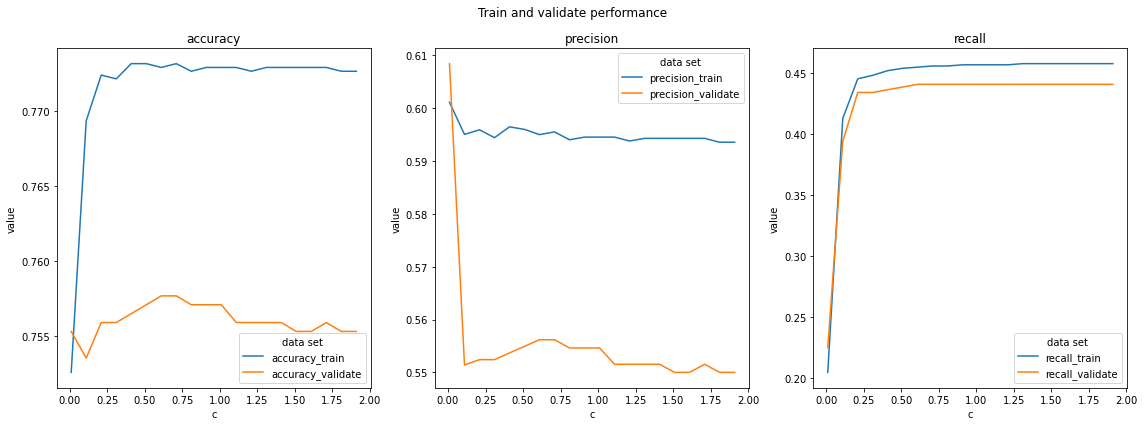

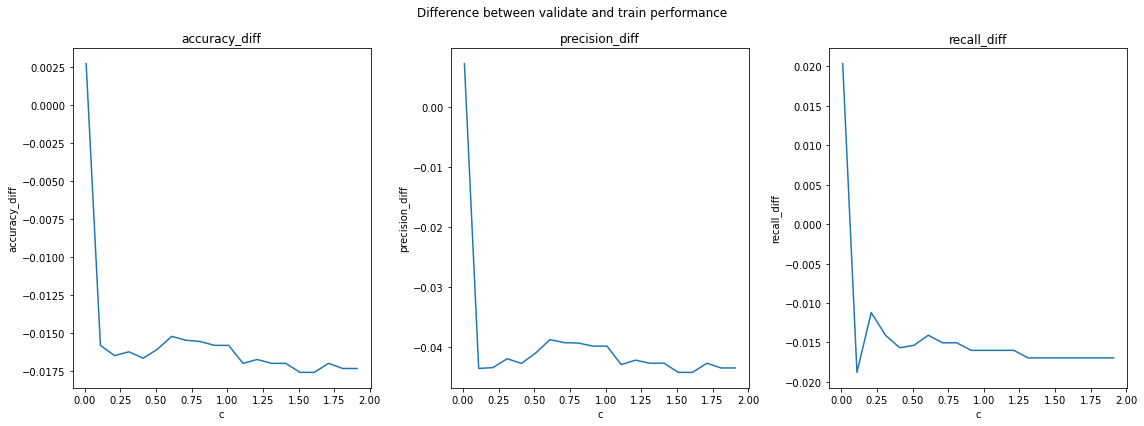

In [36]:
combined_df = plot_train_validate_performance(train_results_df, validate_results_df)

In [37]:
combined_df.accuracy_validate.idxmax()

6

In [38]:
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(x_train, y_train)
    accuracy = model.score(x_validate, y_validate)
    coefs = dict(zip(x_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

# loop through different c values
models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]


(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of different C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
)

,,monthly_charges,is_autopay,is_paperless,internet_service_type_Fiber optic,payment_type_Electronic check
C,accuracy,,,,,
0.001000,0.734000,0.013,-0.138,0.085,0.124,0.152
0.010000,0.736000,0.003,-0.402,0.340,0.704,0.483
0.100000,0.750000,-0.011,-0.469,0.506,1.636,0.604
1.000000,0.751000,-0.015,-0.467,0.536,1.934,0.622
10.000000,0.752000,-0.016,-0.467,0.540,1.971,0.624
100.000000,0.752000,-0.016,-0.468,0.540,1.976,0.624
1000.000000,0.752000,-0.016,-0.467,0.540,1.977,0.623


# <span style="color:red">Modeling Testing Takeaway</span>

### Decision tree Takeaway:
 - Decision Tree Basic:
    - Baseline 73.4%
    - train accuracy 79.16% 

- Train model was most accurate with max depth setting of 9 and min_sample_leaf of 1
   - 80.8%
- Validate was most accurate with max depth setting of 6 and min_sample_leaf of 4
   - 74.6%
   
<span style="color:red">Decision Tree conclusion </span>

 - Train more accurate at depth of 9
 - validate only slightly more accurate than baseline 
 
### Random Forest Takeaway:

  - Max depth of 4 gave accuracy on train : 0.7780 (77.80%)	 Validate: 0.7464	(74.64%)
  -  This is a difference of 0.031558 - approximately 96% similar

<span style="color:red">Conclusion</span>
  - Random forest model with max depth of 4 gave best scenario
  - Not much difference the baseline rate
 
 ### KNN Takeaway

  - Train (k=1) had highest accuracy of 91.72%
  - Validate (k=26) had highest accuracy of 75.12%
  
 ### Logistical Regression
  - Highest accuracy with C = 0.10 accuracy 75.7%

# <span style="color:red"> Conclusion </span>
 - Random forest model with max depth of 4 gave best scenario
 

# Test Phase

 - Using KNN as test based on 91% accuracy rating.  All validate scores were low.

In [46]:
# Change validate to test
k=26
knn = KNeighborsClassifier(n_neighbors = k)
knn = knn.fit(x_train, y_train)
features = ['monthly_charges', 'is_autopay', 'is_paperless',
       'internet_service_type_Fiber optic', 'payment_type_Electronic check']
knn, train_report = knn_train(x_train, y_train,features, target, 46, print_results=False)
accuracy = knn.score(x_validate, y_validate)

In [47]:
accuracy = clf.score(x_validate, y_validate)


# Produce y_predictions that come from the X_validate
y_pred = clf.predict(x_validate)

class_report = classification_report(y_validate, y_pred,output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()

fp_rate = fp/(fp+tn)
fn_rate = fn/(fn+tp)
tp_rate = tp/(tp+fn)
tn_rate = tn/(fp+tn)
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate

print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
print(f"Using features: {features}")
print(f"K of {clf.n_neighbors}")
print(classification_report(y_validate, y_pred))

print(f'Accuracy on validate set: {accuracy:.2f}')
validate_report = {'k':clf.n_neighbors, 
            'accuracy':accuracy, 
            'precision':class_report['1']['precision'], 
            'recall':class_report['1']['recall'],
           'fp_rate':fp_rate,
           'fn_rate':fn_rate,
           'tp_rate':tp_rate,
           'tn_rate':tn_rate}

-----VALIDATE RESULTS: KNeighborsClassifier-----
Using features: ['monthly_charges', 'is_autopay', 'is_paperless', 'internet_service_type_Fiber optic', 'payment_type_Electronic check']
K of 99
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1239
           1       0.53      0.26      0.35       449

    accuracy                           0.74      1688
   macro avg       0.65      0.59      0.59      1688
weighted avg       0.71      0.74      0.71      1688

Accuracy on validate set: 0.74


# CSV for predictions

In [45]:
clf

KNeighborsClassifier(n_neighbors=99)

In [48]:
y_pred_proba = clf.predict_proba(x_test)

In [49]:
# Want customer_id, probability of churn, prediction of churn (1 = churn, 0 = not churn)
y_pred_proba[:5]

array([[0.90909091, 0.09090909],
       [0.93939394, 0.06060606],
       [0.65656566, 0.34343434],
       [0.4040404 , 0.5959596 ],
       [0.77777778, 0.22222222]])

In [53]:
y_pred_proba = np.array([i[1] for i in y_pred_proba])

In [54]:
y_pred_proba

array([0.09090909, 0.06060606, 0.34343434, ..., 0.24242424, 0.09090909,
       0.39393939])

In [55]:
y_pred=clf.predict(x_test)

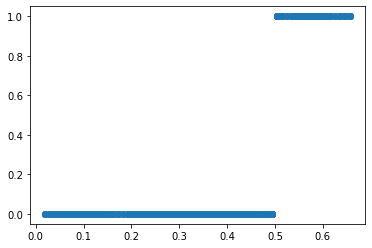

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_pred_proba, y_pred)

In [58]:
test.loc[x_test.index].customer_id

3311    4716-MRVEN
6330    8966-KZXXA
6156    8720-RQSBJ
5313    7504-UWHNB
1176    1730-VFMWO
           ...    
600     0877-SDMBN
3946    5555-RNPGT
3230    4628-CTTLA
349     0516-QREYC
3690    5198-HQAEN
Name: customer_id, Length: 1407, dtype: object

In [59]:
predictions = pd.DataFrame(data={'customer_id':test.loc[x_test.index].customer_id,
                                 'probability_of_churn':y_pred_proba,
                                 'prediction_of_churn':y_pred})

In [ ]:
# Generate CSV
#predictions.to_csv('predictions.csv', index=False)